In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/working/__notebook_source__.ipynb


In [2]:
import bz2 

# train = bz2.open('../input/amazonreviews/train.ft.txt.bz2', 'r')
# test = bz2.open('../input/amazonreviews/test.ft.txt.bz2', 'r')

def load_file(filepath, name_string):
    with open(filepath, 'r') as f:
        doc = f.read()
    sentences = []
    labels = []
    for line in doc.split('\n'):
        if name_string in line:
            sentences.append("")
            if name_string == "test_":
                labels.append(line)
            continue
        if line == "0" or line == "1":
            labels.append(int(line))
        else:
            sentences[-1] += line 
    return sentences, labels

train_sentences, train_labels = load_file('/kaggle/input/vn-sc-dataset/train.crash', name_string='train_')
test_sentences, test_labels = load_file('/kaggle/input/vn-sc-dataset/test.crash', name_string='test_')

In [3]:
from collections import Counter 
import nltk 
from tqdm.notebook import tqdm 

if hasattr(tqdm, '_instance'): tqdm._instance.clear()
    
words = Counter()
for i, sentence in tqdm(enumerate(train_sentences)):
    train_sentences[i] = []
    for w in nltk.word_tokenize(sentence):
        words.update([w.lower()])
        train_sentences[i].append(w.lower())

In [4]:
words = {w:c for w,c in words.items() if c>1}
words = sorted(words, key=words.get, reverse=True)
words = ['_PAD', '_UNK'] + words

In [5]:
print(len(words))

5521


In [6]:
word2int = {w:i for i,w in enumerate(words)}
int2word = {i:w for i,w in enumerate(words)}

In [7]:
for i, sentence in tqdm(enumerate(train_sentences)):
    train_sentences[i] = [word2int[w] if w in word2int else 1 for w in sentence]

In [8]:
for i,sentence in enumerate(test_sentences):
    test_sentences[i] = [word2int[w.lower()] if w.lower() in word2int else 1 for w in nltk.word_tokenize(sentence)]

In [9]:
def pad_sequence(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype=int)
    for i, sentence in enumerate(sentences):
        if len(sentence)!=0:
            features[i, -len(sentence):] = np.array(sentence)[:seq_length]
    return features

In [10]:
seq_length = 200
train_sentences = pad_sequence(train_sentences, seq_length)
test_sentences = pad_sequence(test_sentences, seq_length)

In [11]:
train_labels = np.array(train_labels)
val_split = int(0.2*len(train_sentences))
validation_sentences, validation_labels = train_sentences[:val_split], train_labels[:val_split]
train_sentences, train_labels = train_sentences[val_split:], train_labels[val_split:]

In [12]:
from torch.utils.data import TensorDataset, DataLoader
import torch 

traindata = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
valdata = TensorDataset(torch.from_numpy(validation_sentences), torch.from_numpy(validation_labels))
batch_size = 400
trainloader = DataLoader(traindata, shuffle=True, batch_size=batch_size)
valloader = DataLoader(valdata, shuffle=True, batch_size=batch_size)

In [24]:
import torch.nn as nn 
import torch.nn.functional as F

class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.Embedding = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=0.3, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, h):
        batch_size = x.shape[0]
        x = self.Embedding(x)
        x, h = self.LSTM(x, h)
        x = x.contiguous().view(-1, self.hidden_dim)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(batch_size, -1)
        x = x[:, -1]
        return x, h
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                 weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
        
vocab_size = len(word2int) + 1
embedding_dim = 400
hidden_dim = 512
n_layers = 2 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SentimentNet(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)

In [25]:
########## TRAINING SESSION ###############
import torch.optim as optim 
from tqdm.notebook import tqdm as tqdm


def get_full_batch_size(X, y, batch_size):
    while len(y) < batch_size:
        X = np.concatenate((X, X), axis=0)
        y = np.concatenate((y, y), axis=0)
    X = torch.from_numpy(X[:batch_size])
    y = torch.from_numpy(y[:batch_size])
    return X, y 

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
epochs = 5
batch_size = 400

clip = 5
print_every = 100
h = model.init_hidden(batch_size)
count = 0
model.train()
losses = []
val_min = np.Inf
for epoch in range(epochs):
    training_loss = 0
#     if hasattr(tqdm, '_instance'): tqdm._instance.clear()
    for X, y in tqdm(trainloader):
        if hasattr(tqdm, '_instance'): tqdm._instance.clear()
        if len(y) != batch_size:
            X, y = get_full_batch_size(X, y, batch_size)
        optimizer.zero_grad()
        h = tuple([e.data for e in h])
        X, y = X.to(device), y.to(device)
        out, h = model(X, h)
        loss = criterion(out, y.float())
        training_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        count += 1
    else:
        

        model.eval()
        val_h = model.init_hidden(batch_size)
        val_loss = 0 
        acc = 0
        for X, y in tqdm(valloader):
            if len(y) != batch_size:
                X, y = get_full_batch_size(X, y, batch_size)
            val_h = tuple([e.data for e in val_h])
            X, y = X.to(device), y.to(device)
            out, val_h = model(X, val_h)
            loss = criterion(out, y.float())
            val_loss += loss.item()
            pred = torch.round(out)
            equal = (y == pred)
            acc += torch.mean(equal.float())

        training_loss /= len(trainloader)
        val_loss /= len(valloader)
        print("\nEPOCH %d/%d ..." %(epoch+1, epochs))
        print("Training loss : %.4f" %(training_loss))
        print("Validation loss : %.4f" %(val_loss))
        print("Validation accuracy : %.2f" %(acc/len(valloader)))
        if val_loss < val_min:
            print("Validation loss decrease {:.4f} ---> {:.4f}".format(val_min, val_loss))
            val_min = val_loss
            print("Save weights ...")
            torch.save(model.state_dict(), 'model.h5')
        losses.append([training_loss, val_loss])
        model.train()

        



EPOCH 1/5 ...
Training loss : 0.4775
Validation loss : 0.3861
Validation accuracy : 0.82
Validation loss decrease inf ---> 0.3861
Save weights ...




EPOCH 2/5 ...
Training loss : 0.3362
Validation loss : 0.3221
Validation accuracy : 0.86
Validation loss decrease 0.3861 ---> 0.3221
Save weights ...




EPOCH 3/5 ...
Training loss : 0.2692
Validation loss : 0.2765
Validation accuracy : 0.89
Validation loss decrease 0.3221 ---> 0.2765
Save weights ...




EPOCH 4/5 ...
Training loss : 0.2448
Validation loss : 0.2906
Validation accuracy : 0.89




EPOCH 5/5 ...
Training loss : 0.2144
Validation loss : 0.2680
Validation accuracy : 0.90
Validation loss decrease 0.2765 ---> 0.2680
Save weights ...


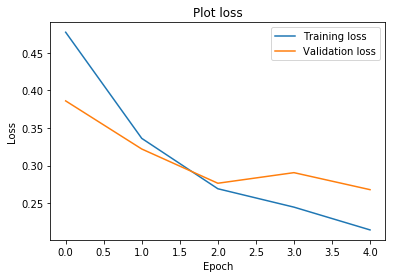

In [27]:
import matplotlib.pyplot as plt 
%matplotlib inline 

losses = np.array(losses)
plt.plot(losses.T[0], label = 'Training loss')
plt.plot(losses.T[1], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot loss')
plt.legend()

In [28]:
model.load_state_dict(torch.load('/kaggle/working/model.h5'))

<All keys matched successfully>

In [29]:
batch_size = 1 
tmp = np.zeros(len(test_sentences))
testdata = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(tmp))
testloader = DataLoader(testdata, batch_size=batch_size)

In [30]:
model.eval()
batch_size = 1 
val_h = model.init_hidden(batch_size)
val_loss = 0 
pred = []
for X, _ in tqdm(testloader):
    val_h = tuple([e.data for e in val_h])
    X = X.to(device)
    out, val_h = model(X, val_h)
    pred.append(int(torch.round(out).item()))

In [31]:
import pandas as pd 
dict = {'id':test_labels, 'label':pred}
df = pd.DataFrame(dict)
df.to_csv('output.csv', index=False)